# Weather Classification

In this task, I applied a simple Convolutional Neural Network (CNN) on the dataset to classify weather images into 4 categories of cloudy, rain, shine, and sunrise. The dataset contains 836 images of different sizes and channels. 

The CNN Model has 4 convolutional layers. RelU activation function is applied right after each convolution layer and then the output is max pooled. I used 3 fully connected layers at the end of the CNN. Adding the fully-connected layers helps learn non-linear combinations of the high-level features outputted by the convolutional layers. Also to avoid overfitting of the model I used batchNormalization on convolutional layers and Dropouts on the fully connected layers.


### Data exploration: 
The dataset was uncleaned. Other than RGB (3-channels) images there is(are) at least a grayscale image (1-channel) and a 4-channels image. I also find images are used more than once with were either resized or flipped. 

The image datases is devided to training data and validation data split ( 80% - 20% ).
The images are resized to 64x64 images. The larger images would make the training slower, and small images would reduce the accuracy of the training. 



# Code

I have included small explanations for each step of the code. I have run the code on my cpu. General steps are as follows:
- Read all images
- Clean and resize images 
- Split images to train/test sets
- Define a Convolutional Neural Network
- Train the model and evaluate the trained model
- Use the model

The requirements for running the code: 

- Jupyter notebook
- pytorch
- torchvision
- torchsummary 
- matplotlib
- skimage
- tqdm


In [6]:
import glob
import numpy as np
import os, sys

# read the image list
image_list = glob.glob('./data/*.jpg')

In [7]:
print(len(image_list))

836


In [8]:
import tqdm
from skimage import io, transform
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

Function resize_img() resize the original images to 64x64 images and also checks for images of different channles and adjust them to a 3-channel image.

In [ ]:
# resize (64x64) and save images
oldpath = "./data/"
path = "./resized/"

def resize_img(image_list):
    for img_name in tqdm.tqdm(image_list):
        image = io.imread(img_name)
        image_resized = transform.resize(image, (64, 64),anti_aliasing=True)
        if len(image_resized.shape) == 2:
            image_resized = np.tile(np.expand_dims(image_resized, axis=-1), (1,1,3))
        assert len(image_resized.shape) == 3, f'{img_name} - {image_resized.shape}'        
        image_resized = image_resized[:, :, :3]
        assert image_resized.shape == (64, 64, 3), f'{img_name} - {image_resized.shape}'
        basename = os.path.basename(img_name)
        image_resized = (image_resized * 255).astype(np.uint8)
        io.imsave(os.path.join(path,basename).replace('.jpg', '.png') , image_resized)

resize_img(image_list)

In [9]:
#read from resized images
resized_image_list = glob.glob('./resized/*.png')

A class made for dataset. A class of dataset makes it easier for accessing images and their labels. 

In [10]:
class weatherDataset(Dataset):
    """weather Dataset."""

    def __init__(self, image_list, image_labels):
        self.images = image_list
        self.labels = image_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.images[idx]
        image = io.imread(img_name)
        label = self.labels[idx]
        image = np.transpose(image, (2,0,1)) # transpose the images to macth the tensor format 
        image = image[:3,:,:]
        assert image.shape == (3, 64, 64), f'{img_name} - {image.shape}'
        
        return image,label

I used 80/20 split for training and testing.

In [27]:
train_size = int(0.8 * len(resized_image_list))
valid_size = int(0.1 * len(resized_image_list))
test_size = len(resized_image_list) - (train_size + valid_size)
train_imageList, valid_imageList, test_imageList = torch.utils.data.random_split(resized_image_list, [train_size, valid_size, test_size])

In [28]:
print(len(train_imageList))
print(len(test_imageList))
print(len(valid_imageList))

668
85
83


In [29]:
# a sinple function to map the images with their labels
def map_filename_to_label(filename):
    if 'cloudy' in filename:
        return 0
    elif 'rain' in filename:
        return 1
    elif 'shine' in filename:
        return 2
    elif 'sunrise' in filename:
        return 3
    
# 
valid_labels = list(map(map_filename_to_label, valid_imageList))
test_labels = list(map(map_filename_to_label, test_imageList))
train_labels = list(map(map_filename_to_label, train_imageList))

In [30]:
# Two datasets are defined for training and test images.  
trainData = weatherDataset(train_imageList, train_labels)
testData = weatherDataset(test_imageList, test_labels)
validData = weatherDataset(test_imageList, test_labels)

Pytorch function DataLoader used to load datasets for traing and testing. I set the batch_size = 4 (larger amounts would cause runtime error). 

In [31]:
trainLoader = DataLoader(trainData, batch_size=4, shuffle=True, num_workers=0,
           drop_last=True, prefetch_factor=2)
testLoader = DataLoader(testData, batch_size=4, shuffle=False, num_workers=0,
           drop_last=True, prefetch_factor=2)
validLoader = DataLoader(validData, batch_size=4, shuffle=False, num_workers=0,
           drop_last=True, prefetch_factor=2)

Here you see some example images from training set.

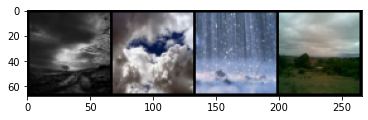

./resized\cloudy233.png ./resized\cloudy233.png ./resized\shine43.png ./resized\cloudy233.png


In [32]:
import matplotlib.pyplot as plt

# functions to show an image

batch_size = 4
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainLoader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % train_imageList[labels[j]] for j in range(batch_size)))

Here I defined a CNN with 4 conv2d layers and 3 fully connected layers. 

In [33]:
#Define a Convolutional Neural Network

import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3 , padding =1 , bias=False) 
        self.conv2_bn1 = nn.BatchNorm2d(16)       
        self.conv2 = nn.Conv2d(16, 32, 3 , padding =1 , bias=False)
        self.conv2_bn2 = nn.BatchNorm2d(32)       
        self.conv3 = nn.Conv2d(32, 64, 3 , padding =1 , bias=False) 
        self.conv2_bn3 = nn.BatchNorm2d(64)      
        self.conv4 = nn.Conv2d(64, 128, 3 , padding =1 , bias=False) 
        self.conv2_bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 *4 *4, 64)    
        self.fc1_do = nn.Dropout(p = 0.2)
        self.fc2 = nn.Linear(64, 32)
        self.fc2_do = nn.Dropout(p = 0.2)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.conv1(x) # 3x64x64 -> 16x64x64
        x = self.pool(F.relu(self.conv2_bn1(x))) # 16x64x64 -> 16x32x32        
        x = self.conv2(x) # 16x32x32 -> 32x32x32
        x = self.pool(F.relu(self.conv2_bn2(x))) #  32x32x32 ->  32x16x16        
        x = self.conv3(x) #  32x16x16 ->  64x16x16
        x = self.pool(F.relu(self.conv2_bn3(x))) #  64x16x16 ->  64x8x8
        x = self.conv4(x) #  64x8x8 ->  128x8x8       
        x = self.pool(F.relu(self.conv2_bn4(x))) #  128x8x8 ->  128x4x4                
        x = torch.flatten(x, 1) # 512
        x = F.relu(self.fc1_do(self.fc1(x))) # 120
        x = F.relu(self.fc2_do(self.fc2(x))) # 84
        x = self.fc3(x) # 4
        x = nn.Sigmoid()(x)
        return x


In [34]:
# Use torchsummary to visualize the model
from torchsummary import summary
net = Net()
summary(net, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,608
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,432
       BatchNorm2d-8           [-1, 64, 16, 16]             128
         MaxPool2d-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 128, 8, 8]          73,728
      BatchNorm2d-11            [-1, 128, 8, 8]             256
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                   [-1, 64]         131,136
          Dropout-14                   

### Optimizer 

I usd torch.optim to construct an optimizer object. It will hold the current state and will update the parameters based on the computed gradients. I used the stochastic gradient descent method, however, Adam is another method that could be used. 

I used cross entropy loss as it's commonly used in classification tasks. It measures the performance of a classification model whose output is a probability value between 0 and 1. 


In [35]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [36]:
criterion = nn.CrossEntropyLoss()

In [52]:
#reset network
for layer in net.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

### Training the model

Here, I trained the model. To see accuracy and loss values, the model being tested in each epoch after being trained.
The best model with lowest validation loss will be saved in the directory. 

In [53]:
train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]
best_val_loss = 100000

for epoch in range(60):  # loop over the dataset multiple times
    correct_tr = 0
    total_tr = 0
    running_loss_tr = 0.0
    
    net.train() # traing mode
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float() )
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total_tr += labels.size(0)
        correct_tr += (predicted == labels).sum().item()

        # sum of losses
        running_loss_tr += loss.item()
            
   
    net.eval() 
    correct_val = 0
    total_val = 0
    running_loss_valid = 0.0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in validLoader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.float())
            loss = criterion(outputs, labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            # sum of losses
            running_loss_valid += loss.item()
    print('epoch: %.0f' %(epoch))
    # print Accuracy and losses for train set in each epoch
    train_loss=running_loss_tr/len(trainLoader)
    tr_accu = 100 * correct_tr / total_tr
    
    train_losses.append(train_loss)
    train_accu.append(tr_accu)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,tr_accu))
    
    # print Accuracy and losses for test set in each epoch
    valid_loss=running_loss_valid/len(validLoader)
    valid_accu = 100 * correct_val / total_val

    eval_losses.append(valid_loss)
    eval_accu.append(valid_accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(valid_loss,valid_accu)) 
    
    #stopping criteria when reached to lowest validation loss 
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        tPATH = f'./weather_net_{epoch}_{int(valid_loss)}_{int(valid_accu)}.pth'
        torch.save(net.state_dict(), tPATH)
    if valid_loss >  best_val_loss + 1:
        print('early stop')
        break 
    print('\n')
   
print('Finished Training')

epoch: 0
Train Loss: 1.340 | Accuracy: 36.377
Test Loss: 1.267 | Accuracy: 38.095


epoch: 1
Train Loss: 1.228 | Accuracy: 45.210
Test Loss: 1.140 | Accuracy: 63.095


epoch: 2
Train Loss: 1.148 | Accuracy: 56.287
Test Loss: 1.085 | Accuracy: 69.048


epoch: 3
Train Loss: 1.097 | Accuracy: 62.874
Test Loss: 1.043 | Accuracy: 79.762


epoch: 4
Train Loss: 1.059 | Accuracy: 68.862
Test Loss: 1.009 | Accuracy: 70.238


epoch: 5
Train Loss: 1.042 | Accuracy: 65.719
Test Loss: 1.000 | Accuracy: 72.619


epoch: 6
Train Loss: 1.014 | Accuracy: 69.012
Test Loss: 1.001 | Accuracy: 69.048


epoch: 7
Train Loss: 0.988 | Accuracy: 73.952
Test Loss: 0.997 | Accuracy: 73.810


epoch: 8
Train Loss: 0.983 | Accuracy: 72.904
Test Loss: 0.964 | Accuracy: 82.143


epoch: 9
Train Loss: 0.972 | Accuracy: 76.946
Test Loss: 0.981 | Accuracy: 82.143


epoch: 10
Train Loss: 0.956 | Accuracy: 77.695
Test Loss: 0.958 | Accuracy: 82.143


epoch: 11
Train Loss: 0.939 | Accuracy: 81.287
Test Loss: 0.939 | Accuracy:

### Accuracy and loss

The first plot shows the accuracy of the training set vs test set, and second plot shows the losses of the training set vs test set.
As in the plots we can see the accuracy stopes around 96%. 

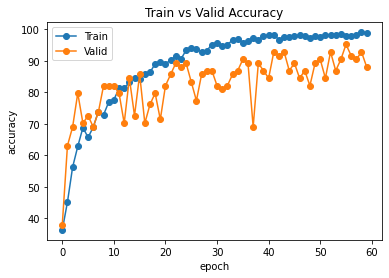

In [54]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()


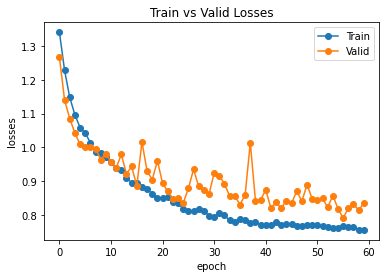

In [55]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

## Use the Model 

For prediction, we load the best model and run the network to test the test_dataset. 
The model was able to predict the test images with 96% accuracy.  
Below you can see 4 example images with the predictions and the grand truth labels. Where {0: cloudy,  1: rain, 2: shine, 3: sunrise}.

In [56]:
# load the best model  
Best_Model_Path = './weather_net_55_0_95.pth'  
net.load_state_dict(torch.load(Best_Model_Path))

<All keys matched successfully>

In [91]:
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score
classes = ('cloudy', 'rain', 'shine', 'sunrise')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

y_true = []
y_pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs.data, 1)
        for i in range(predictions.shape[0]):
            y_true.append(labels[i])
            y_pred.append(predictions[i])
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
    
# print confusion matrix
print ('\n Confusion Matrix')
print (confusion_matrix(y_true, y_pred))

print ('\nF1', f1_score(y_true, y_pred, average=None))
print ('Sensitivity', recall_score(y_true, y_pred, average=None))
print ('Precision', precision_score(y_true, y_pred, average=None))
print ('Accuracy', accuracy_score(y_true, y_pred)) 


Accuracy for class cloudy is: 96.8 %
Accuracy for class rain  is: 95.8 %
Accuracy for class shine is: 95.7 %
Accuracy for class sunrise is: 83.3 %

 Confusion Matrix
[[30  1  0  0]
 [ 0 23  1  0]
 [ 1  0 22  0]
 [ 0  0  1  5]]

F1 [0.96774194 0.95833333 0.93617021 0.90909091]
Sensitivity [0.96774194 0.95833333 0.95652174 0.83333333]
Precision [0.96774194 0.95833333 0.91666667 1.        ]
Accuracy 0.9523809523809523


Predicted: tensor([1, 0, 3, 0])


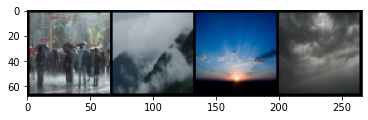

GroundTruth: tensor([1, 0, 3, 0])


In [92]:
print(f'Predicted: {str(predicted)}')
imshow(torchvision.utils.make_grid(images))
print(f'GroundTruth: {labels}')

# Next steps

Furture evaluation could be done on this assignmnet. 
For example see the confusion matrix and see compare the accuracy of the model for each classes. 
The dataset is relatively small and unbalanced (#rain=213, #cloudy=300, #sunrise=70, #shine=253), it could be augmented by flipping images.
I used the simples CNN model, which was enough for this task. However, more complex networks could be investigated for  classification.

